In [1]:
import feature_engineering as Fe
import pandas as pd
import os
import random
import math
from tqdm import tqdm
import numpy as np
import time

# CSV 만들기

In [2]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요!
DATA_PATH = '/opt/ml/input/data/train_data.csv'
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True) 

In [3]:
df #2266586

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [4]:
# dtype = {
#     'userID': 'int16',
#     'answerCode': 'int8',
#     'KnowledgeTag': 'int16'
# }   

# train = pd.read_csv("/opt/ml/input/data/cv_train_data.csv", dtype=dtype, parse_dates=['Timestamp'])
# valid = pd.read_csv("/opt/ml/input/data/cv_valid_data.csv", dtype=dtype, parse_dates=['Timestamp'])

In [5]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요!
test_csv_file_path = '/opt/ml/input/data/test_data.csv'
test = pd.read_csv(test_csv_file_path, dtype=dtype, parse_dates=['Timestamp'])
test = test.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [6]:
test

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623
...,...,...,...,...,...,...
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244
260112,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244


In [7]:
# 문제 번호
df['problem_number'] = df['assessmentItemID'].apply(lambda x : int(x[-3:]))
test['problem_number'] = test['assessmentItemID'].apply(lambda x : int(x[-3:]))

In [8]:
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,problem_number
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,2
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,3
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,4
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,5


In [22]:
correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum', 'skew', 'std'])
correct_t.columns = ["test_mean", 'test_sum', "test_skew", "test_std"]
correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum','skew', 'std'])
correct_k.columns = ["tag_mean", 'tag_sum', "tag_skew", "tag_std"]
correct_a = df.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum','skew','std'])
correct_a.columns = ["ass_mean", 'ass_sum', 'ass_skew', 'ass_std']
correct_p = df.groupby(['problem_number'])['answerCode'].agg(['mean', 'sum'])
correct_p.columns = ["prb_mean", 'prb_sum']

In [23]:
prac = df.copy()

# FE

In [9]:
# #time elapsed 
# diff = prac.loc[:, ['userID','Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
# diff = diff.fillna(pd.Timedelta(seconds=0))
# diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
# prac['elapsed'] = diff
# prac['elapsed'] = prac['elapsed'].apply(lambda x : x if x <650 and x >=0 else 0)

In [19]:
# # question class
# prac["question_class"] = df["assessmentItemID"].apply(lambda x: x[2])

# prac['grade']=df['testId'].apply(lambda x : int(x[1:4])//10)

# # question class(assessmentItemID 두 번째 숫자) 기준 mean, sum


In [24]:
prac

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,problem_number
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,2
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,3
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,4
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,5
...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,5
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,3


In [25]:
def Question_acc(df): # 문제별 acc
    assessmentItemID_groupby = df.groupby("assessmentItemID").agg(
        {"answerCode": "mean"}
    )

    df["Question_acc"] = assessmentItemID_groupby["answerCode"][
        df["assessmentItemID"]
    ].values
    return df


def KnowledgeTag_acc(df): #태그별 acc
    KnowledgeTag_groupby = df.groupby("KnowledgeTag").agg({"answerCode": "mean"})

    df["KnowledgeTag_acc"] = KnowledgeTag_groupby["answerCode"][
        df["KnowledgeTag"]
    ].values

    return df


In [26]:
#time elapsed 
def change_elapsed(data):
    return data["elapsed"] if not data["is_elapsed_more_600"] else data["userID_testId_elapsed_mean"]
    
def change_log_elapsed(data):
    return data["log_elapsed"] if not data["is_elapsed_more_10"] else data["userID_testId_log_elapsed_mean"]

def get_elapsed(df):
    diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().shift(-1).fillna(pd.Timedelta(seconds=0))
    elapsed = diff['Timestamp'].apply(lambda x: x.total_seconds())
    elapsed_log = diff['Timestamp'].apply(lambda x: np.log1p(x.total_seconds()))
    
    df['elapsed'] = elapsed
    df['log_elapsed'] = elapsed_log
    
    ### 특정 기준치를 벗어나면 해당 user의 해당 test지에 대한 평균 elapsed time으로 교체
    df["is_elapsed_more_600"] = df["elapsed"].apply(lambda x : True if x > 600 else False)
    df["is_elapsed_more_10"] = df["log_elapsed"].apply(lambda x : True if x > 10 else False)
    
    group_userID_testId = df[~df["is_elapsed_more_600"]].groupby(["userID", "testId"])["elapsed"].agg(["mean"])
    group_userID_testId = group_userID_testId.reset_index()
    group_userID_testId.columns = ["userID", "testId", "userID_testId_elapsed_mean"]

    group_userID_testId_log = df[~df["is_elapsed_more_10"]].groupby(["userID", "testId"])["log_elapsed"].agg(["mean"])
    group_userID_testId_log = group_userID_testId_log.reset_index()
    group_userID_testId_log.columns = ["userID", "testId", "userID_testId_log_elapsed_mean"]

    df = pd.merge(df, group_userID_testId, on=["userID", "testId"], how="left")
    df = pd.merge(df, group_userID_testId_log, on=["userID", "testId"], how="left")

    df["elapsed"] = df.apply(change_elapsed, axis=1)
    df["log_elapsed"] = df.apply(change_log_elapsed, axis=1)
    
    df = df.drop(['is_elapsed_more_600', 'is_elapsed_more_10', 'userID_testId_elapsed_mean', 'userID_testId_log_elapsed_mean'], axis=1)
    df = df.fillna(0.0)
    
    return df

In [27]:
def is_probably_easy(row):
    delta = row.delta
    delta_thres = 1 # hour
    
    is_prev_ord = row.is_previous_ordered
    is_prev_dec = row.is_previous_decreasing
    is_prev_ord_shift = row.is_prev_ord_shift
    is_prev_dec_shift = row.is_prev_dec_shift
    
    case = (is_prev_ord_shift, is_prev_dec_shift, is_prev_ord, is_prev_dec)
    
    probably_easy_l = [
        (np.nan, np.nan, -1, -1),
        (-1, -1, 1, 0),
        (1, 0, 1, 0),
        (1, 0, 0, 0),
    ]
    
    if pd.isnull(delta) or delta > pd.Timedelta(hours=1):
        return -1
    elif case in probably_easy_l:
        return 1
    else:
        return 0

def is_previous_decreasing(row):
    q_num = row.problem_number
    q_num_prev = row.q_num_prev
    delta = row.delta
    delta_thres = 1 # hour
    
    if pd.isnull(delta) or delta > pd.Timedelta(hours=1):
        return -1
    elif q_num < q_num_prev:
        return 1
    else:
        return 0

def add_last_problem(df):
    new = []
    pre = df['testId'][0]
    for idx in df['testId']:
        if pre != idx :
            new[-1]=-1
            pre = idx
        new.append(0)
    df['last_problem'] = new
    return df

def is_previous_ordered(row):
    q_num = row.problem_number
    q_num_prev = row.q_num_prev
    delta = row.delta
    delta_thres = 1 # hour
    
    if pd.isnull(delta) or delta > pd.Timedelta(hours=1):
        return -1
    elif q_num == q_num_prev + 1:
        return 1
    else:
        return 0

In [28]:
def ELO_function (df) :
    def get_new_theta(is_good_answer, beta, left_asymptote, theta, nb_previous_answers):
        return theta + learning_rate_theta(nb_previous_answers) * (
            is_good_answer - probability_of_good_answer(theta, beta, left_asymptote)
        )

    def get_new_beta(is_good_answer, beta, left_asymptote, theta, nb_previous_answers):
        return beta - learning_rate_beta(nb_previous_answers) * (
            is_good_answer - probability_of_good_answer(theta, beta, left_asymptote)
        )

    def learning_rate_theta(nb_answers):
        return max(0.3 / (1 + 0.01 * nb_answers), 0.04)

    def learning_rate_beta(nb_answers):
        return 1 / (1 + 0.05 * nb_answers)

    def probability_of_good_answer(theta, beta, left_asymptote):
        return left_asymptote + (1 - left_asymptote) * sigmoid(theta - beta)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    def estimate_parameters(answers_df, granularity_feature_name='assessmentItemID'):
        item_parameters = {
            granularity_feature_value: {"beta": 0, "nb_answers": 0}
            for granularity_feature_value in np.unique(answers_df[granularity_feature_name])
        }
        student_parameters = {
            student_id: {"theta": 0, "nb_answers": 0}
            for student_id in np.unique(answers_df.userID)
        }

        print("Parameter estimation is starting...")

        for student_id, item_id, left_asymptote, answered_correctly in tqdm(
            zip(answers_df.userID.values, answers_df[granularity_feature_name].values, answers_df.left_asymptote.values, answers_df.answerCode.values)
        ):
            theta = student_parameters[student_id]["theta"]
            beta = item_parameters[item_id]["beta"]

            item_parameters[item_id]["beta"] = get_new_beta(
                answered_correctly, beta, left_asymptote, theta, item_parameters[item_id]["nb_answers"],
            )
            student_parameters[student_id]["theta"] = get_new_theta(
                answered_correctly, beta, left_asymptote, theta, student_parameters[student_id]["nb_answers"],
            )

            item_parameters[item_id]["nb_answers"] += 1
            student_parameters[student_id]["nb_answers"] += 1

        print(f"Theta & beta estimations on {granularity_feature_name} are completed.")
        return student_parameters, item_parameters
    
    def gou_func (theta, beta) :
        return 1 / (1 + np.exp(-(theta - beta)))
    
    
    df['left_asymptote'] = 0

    print(f"Dataset of shape {df.shape}")
    print(f"Columns are {list(df.columns)}")

    student_parameters, item_parameters = estimate_parameters(df)
    
    prob = [gou_func(student_parameters[student]['theta'], item_parameters[item]['beta']) for student, item in zip(df.userID.values, df.assessmentItemID.values)]
    
    df['elo_prob'] = prob
    
    return df

In [31]:
def feature_engineering(df):

    print('-'*20, 'Feature Engineering Start', '-'*20)
    start_time = time.time()
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    df = add_last_problem(df)
    
    # 문제,태그별 평균
    df = Question_acc(df)
    df = KnowledgeTag_acc(df)
    

    #solved_question , 유저별 푼 문제 수
    df["solved_question"] = df.groupby(["userID"]).cumcount()
    

    # time elapsed
    df = get_elapsed(df)
    
    # elo 추가
    df = ELO_function(df)
    
    df['hour'] = df['Timestamp'].dt.hour
    df['day_of_week'] = df['Timestamp'].dt.dayofweek
    
    # 푸는 시간
    # diff = df.loc[:, ['userID','Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
    # diff = diff.fillna(pd.Timedelta(seconds=0))
    # diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
    # df['elapsed'] = diff
    # df['elapsed'] = df['elapsed'].apply(lambda x : x if x <650 and x >=0 else 0)
    
    df['grade']=df['testId'].apply(lambda x : int(x[1:4])//10)
    df['mid'] = df['testId'].apply(lambda x : int(x[-3:]))
    df['problem_number'] = df['assessmentItemID'].apply(lambda x : int(x[-3:]))
    
#     stu_test_groupby = df.groupby(['userID', 'testId'])
#     df.loc[:, "delta"] = stu_test_groupby['Timestamp'].diff()
#     df['q_num_prev'] = df.problem_number.shift()
#     df['is_previous_ordered'] =  df.apply(lambda row: is_previous_ordered(row), axis=1)
#     df['is_previous_decreasing'] = df.apply(lambda row: is_previous_decreasing(row), axis=1)
#     df['is_prev_ord_shift'] = df.is_previous_ordered.shift()
#     df['is_prev_dec_shift'] = df.is_previous_decreasing.shift()
#     df['is_probably_easy'] = df.apply(lambda row: is_probably_easy(row), axis=1)
#     df.drop(labels=['delta', 'q_num_prev', 'is_previous_ordered',
#                     'is_previous_decreasing', 'is_prev_ord_shift', 'is_prev_dec_shift'], axis=1, inplace=True)
    
    correct_h = df.groupby(['hour'])['answerCode'].agg(['mean', 'sum'])
    correct_h.columns = ["hour_mean", 'hour_sum']
    correct_d = df.groupby(['day_of_week'])['answerCode'].agg(['mean', 'sum'])
    correct_d.columns = ["day_of_weak_mean", 'day_of_week_sum'] 
    

    
    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    df = pd.merge(df, correct_a, on=['assessmentItemID'], how="left")
    df = pd.merge(df, correct_p, on=['problem_number'], how="left")
    df = pd.merge(df, correct_h, on=['hour'], how="left")
    df = pd.merge(df, correct_d, on=['day_of_week'], how="left")

    o_df = df[df['answerCode']==1]
    x_df = df[df['answerCode']==0]
    
    elp_k = df.groupby(['KnowledgeTag'])['elapsed'].agg('mean').reset_index()
    elp_k.columns = ['KnowledgeTag',"tag_elp"]
    elp_k_o = o_df.groupby(['KnowledgeTag'])['elapsed'].agg('mean').reset_index()
    elp_k_o.columns = ['KnowledgeTag', "tag_elp_o"]
    elp_k_x = x_df.groupby(['KnowledgeTag'])['elapsed'].agg('mean').reset_index()
    elp_k_x.columns = ['KnowledgeTag', "tag_elp_x"]
    
    df = pd.merge(df, elp_k, on=['KnowledgeTag'], how="left")
    df = pd.merge(df, elp_k_o, on=['KnowledgeTag'], how="left")
    df = pd.merge(df, elp_k_x, on=['KnowledgeTag'], how="left")

    ass_k = df.groupby(['assessmentItemID'])['elapsed'].agg('mean').reset_index()
    ass_k.columns = ['assessmentItemID',"ass_elp"]
    ass_k_o = o_df.groupby(['assessmentItemID'])['elapsed'].agg('mean').reset_index()
    ass_k_o.columns = ['assessmentItemID',"ass_elp_o"]
    ass_k_x = x_df.groupby(['assessmentItemID'])['elapsed'].agg('mean').reset_index()
    ass_k_x.columns = ['assessmentItemID',"ass_elp_x"]

    df = pd.merge(df, ass_k, on=['assessmentItemID'], how="left")
    df = pd.merge(df, ass_k_o, on=['assessmentItemID'], how="left")
    df = pd.merge(df, ass_k_x, on=['assessmentItemID'], how="left")

    prb_k = df.groupby(['problem_number'])['elapsed'].agg('mean').reset_index()
    prb_k.columns = ['problem_number',"prb_elp"]
    prb_k_o = o_df.groupby(['problem_number'])['elapsed'].agg('mean').reset_index()
    prb_k_o.columns = ['problem_number',"prb_elp_o"]
    prb_k_x = x_df.groupby(['problem_number'])['elapsed'].agg('mean').reset_index()
    prb_k_x.columns = ['problem_number',"prb_elp_x"]

    df = pd.merge(df, prb_k, on=['problem_number'], how="left")
    df = pd.merge(df, prb_k_o, on=['problem_number'], how="left")
    df = pd.merge(df, prb_k_x, on=['problem_number'], how="left")
    
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = (df['user_correct_answer']/df['user_total_answer']).fillna(0)
    df['Grade_o'] = df.groupby(['userID','grade'])['answerCode'].transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df['GradeCount'] = df.groupby(['userID','grade']).cumcount()
    df['GradeAcc'] = (df['Grade_o']/df['GradeCount']).fillna(0)
    df['GradeElp'] = df.groupby(['userID','grade'])['elapsed'].transform(lambda x: x.cumsum()).fillna(0)
    df['GradeMElp'] = df['GradeElp']/[v if v != 0 else 1 for v in df['GradeCount'].values]
    
    f = lambda x : len(set(x))
    test = df.groupby(['testId']).agg({
        'problem_number':'max',
        'KnowledgeTag':f
    })
    test.reset_index(inplace=True)

    test.columns = ['testId','problem_count',"tag_count"]
    
    df = pd.merge(df,test,on='testId',how='left')
    
    gdf = df[['userID','testId','problem_number','grade','Timestamp']].sort_values(by=['userID','grade','Timestamp'])
    gdf['buserID'] = gdf['userID'] != gdf['userID'].shift(1)
    gdf['bgrade'] = gdf['grade'] != gdf['grade'].shift(1)
    gdf['first'] = gdf[['buserID','bgrade']].any(axis=1).apply(lambda x : 1- int(x))
    gdf['RepeatedTime'] = gdf['Timestamp'].diff().fillna(pd.Timedelta(seconds=0)) 
    gdf['RepeatedTime'] = gdf['RepeatedTime'].apply(lambda x: x.total_seconds()) * gdf['first']
    df['RepeatedTime'] = gdf['RepeatedTime'].apply(lambda x : math.log(x+1))
    
    df['prior_KnowledgeTag_frequency'] = df.groupby(['userID','KnowledgeTag']).cumcount()
    
    df['problem_position'] = df['problem_number'] / df["problem_count"]
    df['solve_order'] = df.groupby(['userID','testId']).cumcount()
    df['solve_order'] = df['solve_order'] - df['problem_count']*(df['solve_order'] > df['problem_count']).apply(int) + 1
    df['retest'] = (df['solve_order'] > df['problem_count']).apply(int)
    T = df['solve_order'] != df['problem_number']
    TT = T.shift(1)
    TT[0] = False
    df['solved_disorder'] = (TT.apply(lambda x : not x) & T).apply(int)
    
    df['testId'] = df['testId'].apply(lambda x : int(x[1:4]+x[-3]))
    
    print('-'*20, 'Feature Engineering End', '-'*20)
    print(f"Feature Engineering에 걸린 시간 : {time.time() - start_time}s")
    return df

In [32]:
prac = feature_engineering(prac)
prac

-------------------- Feature Engineering Start --------------------
Dataset of shape (2266586, 14)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'problem_number', 'last_problem', 'Question_acc', 'KnowledgeTag_acc', 'solved_question', 'elapsed', 'log_elapsed', 'left_asymptote']
Parameter estimation is starting...


2266586it [00:58, 38534.70it/s]


Theta & beta estimations on assessmentItemID are completed.
-------------------- Feature Engineering End --------------------
Feature Engineering에 걸린 시간 : 250.14783668518066s


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,problem_number,last_problem,Question_acc,KnowledgeTag_acc,...,GradeElp,GradeMElp,problem_count,tag_count,RepeatedTime,prior_KnowledgeTag_frequency,problem_position,solve_order,retest,solved_disorder
0,0,A060001001,600,1,2020-03-24 00:17:11,7224,1,0,0.982063,0.955022,...,3.0,3.000000,7,2,0.000000,0,0.142857,1,0,0
1,0,A060001002,600,1,2020-03-24 00:17:14,7225,2,0,0.964126,0.913187,...,11.0,11.000000,7,2,1.386294,0,0.285714,2,0,0
2,0,A060001003,600,1,2020-03-24 00:17:22,7225,3,0,0.910314,0.913187,...,18.0,9.000000,7,2,2.197225,1,0.428571,3,0,0
3,0,A060001004,600,1,2020-03-24 00:17:29,7225,4,0,0.968610,0.913187,...,25.0,8.333333,7,2,2.079442,2,0.571429,4,0,0
4,0,A060001005,600,1,2020-03-24 00:17:36,7225,5,0,0.941704,0.913187,...,36.0,9.000000,7,2,2.079442,3,0.714286,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,300,0,2020-06-05 06:50:21,438,5,-1,0.435252,0.689706,...,275.0,68.750000,5,1,3.218876,4,1.000000,5,0,0
2266582,7441,A040165001,401,1,2020-08-21 01:06:39,8836,1,0,0.649635,0.697874,...,11.0,11.000000,4,1,0.000000,0,0.250000,1,0,0
2266583,7441,A040165002,401,1,2020-08-21 01:06:50,8836,2,0,0.635036,0.697874,...,57.0,57.000000,4,1,2.484907,1,0.500000,2,0,0
2266584,7441,A040165003,401,1,2020-08-21 01:07:36,8836,3,0,0.791971,0.697874,...,130.0,65.000000,4,1,3.850148,2,0.750000,3,0,0


In [34]:
test = feature_engineering(test)
test

-------------------- Feature Engineering Start --------------------
Dataset of shape (260114, 14)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'problem_number', 'last_problem', 'Question_acc', 'KnowledgeTag_acc', 'solved_question', 'elapsed', 'log_elapsed', 'left_asymptote']
Parameter estimation is starting...


260114it [00:06, 38588.42it/s]


Theta & beta estimations on assessmentItemID are completed.
-------------------- Feature Engineering End --------------------
Feature Engineering에 걸린 시간 : 27.786059141159058s


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,problem_number,last_problem,Question_acc,KnowledgeTag_acc,...,GradeElp,GradeMElp,problem_count,tag_count,RepeatedTime,prior_KnowledgeTag_frequency,problem_position,solve_order,retest,solved_disorder
0,3,A050023001,500,1,2020-01-09 10:56:31,2626,1,0,0.750000,0.587097,...,26.0,26.000000,7,4,0.000000,0,0.142857,1,0,0
1,3,A050023002,500,1,2020-01-09 10:56:57,2626,2,0,0.562500,0.587097,...,120.0,120.000000,7,4,3.295837,1,0.285714,2,0,0
2,3,A050023003,500,0,2020-01-09 10:58:31,2625,3,0,0.343750,0.588517,...,125.0,62.500000,7,4,4.553877,0,0.428571,3,0,0
3,3,A050023004,500,0,2020-01-09 10:58:36,2625,4,0,0.500000,0.588517,...,132.0,44.000000,7,4,1.791759,1,0.571429,4,0,0
4,3,A050023006,500,0,2020-01-09 10:58:43,2623,6,0,0.281250,0.581986,...,135.0,33.750000,7,4,2.079442,0,0.857143,5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,7439,A040130001,401,0,2020-10-14 23:07:23,8832,1,0,0.380952,0.584848,...,467.8,42.527273,5,2,15.367586,0,0.200000,1,0,0
260110,7439,A040130002,401,1,2020-10-14 23:07:41,8832,2,0,0.523810,0.584848,...,488.8,40.733333,5,2,2.944439,1,0.400000,2,0,0
260111,7439,A040130003,401,1,2020-10-14 23:08:02,8244,3,0,0.761905,0.725490,...,577.8,44.446154,5,2,3.091042,0,0.600000,3,0,0
260112,7439,A040130004,401,1,2020-10-14 23:09:31,8244,4,0,0.857143,0.725490,...,609.8,43.557143,5,2,4.499810,1,0.800000,4,0,0


In [36]:
prac.to_csv('/opt/ml/input/data/FE_dataset/train_FE+.csv', index = False)
test.to_csv('/opt/ml/input/data/FE_dataset/test_FE+.csv', index = False)

# Train, Valid 나누기

In [38]:

# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    valid = df[df['userID'].isin(user_ids) == False]

    #valid데이터셋은 각 유저의 마지막 interaction만 추출
    #valid = valid[valid['userID'] != valid['userID'].shift(-1)]
    return train, valid

In [39]:
train, valid = custom_train_test_split(prac)


In [46]:
valid

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,problem_number,last_problem,Question_acc,KnowledgeTag_acc,...,GradeElp,GradeMElp,problem_count,tag_count,RepeatedTime,prior_KnowledgeTag_frequency,problem_position,solve_order,retest,solved_disorder
1954,5,A080001001,800,1,2020-02-12 20:00:20,4604,1,0,0.480447,0.489777,...,9.0,9.000000,6,5,0.000000,0,0.166667,1,0,0
1955,5,A080001002,800,1,2020-02-12 20:00:29,1356,2,0,0.695531,0.616612,...,67.0,67.000000,6,5,2.302585,0,0.333333,2,0,0
1956,5,A080001003,800,1,2020-02-12 20:01:27,1396,3,0,0.835196,0.721170,...,102.0,51.000000,6,5,4.077537,0,0.500000,3,0,0
1957,5,A080001004,800,1,2020-02-12 20:02:02,4604,4,0,0.558659,0.489777,...,167.0,55.666667,6,5,3.583519,1,0.666667,4,0,0
1958,5,A080001005,800,1,2020-02-12 20:03:07,1397,5,0,0.645251,0.735294,...,167.0,41.750000,6,5,4.189655,0,0.833333,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,300,0,2020-06-05 06:50:21,438,5,-1,0.435252,0.689706,...,275.0,68.750000,5,1,3.218876,4,1.000000,5,0,0
2266582,7441,A040165001,401,1,2020-08-21 01:06:39,8836,1,0,0.649635,0.697874,...,11.0,11.000000,4,1,0.000000,0,0.250000,1,0,0
2266583,7441,A040165002,401,1,2020-08-21 01:06:50,8836,2,0,0.635036,0.697874,...,57.0,57.000000,4,1,2.484907,1,0.500000,2,0,0
2266584,7441,A040165003,401,1,2020-08-21 01:07:36,8836,3,0,0.791971,0.697874,...,130.0,65.000000,4,1,3.850148,2,0.750000,3,0,0


In [40]:
train = train.fillna(0)
valid = valid.fillna(0)
test = test.fillna(0)

In [8]:
train.to_csv('/opt/ml/input/data/FE_dataset/train_FE+.csv', index = False)
valid.to_csv('/opt/ml/input/data/FE_dataset/valid_FE+.csv', index = False)
test.to_csv('/opt/ml/input/data/FE_dataset/test_FE+.csv', index = False)


In [41]:
train.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'problem_number', 'last_problem', 'Question_acc',
       'KnowledgeTag_acc', 'solved_question', 'elapsed', 'log_elapsed',
       'left_asymptote', 'elo_prob', 'hour', 'day_of_week', 'grade', 'mid',
       'test_mean', 'test_sum', 'test_skew', 'test_std', 'tag_mean', 'tag_sum',
       'tag_skew', 'tag_std', 'ass_mean', 'ass_sum', 'ass_skew', 'ass_std',
       'prb_mean', 'prb_sum', 'hour_mean', 'hour_sum', 'day_of_weak_mean',
       'day_of_week_sum', 'tag_elp', 'tag_elp_o', 'tag_elp_x', 'ass_elp',
       'ass_elp_o', 'ass_elp_x', 'prb_elp', 'prb_elp_o', 'prb_elp_x',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'Grade_o',
       'GradeCount', 'GradeAcc', 'GradeElp', 'GradeMElp', 'problem_count',
       'tag_count', 'RepeatedTime', 'prior_KnowledgeTag_frequency',
       'problem_position', 'solve_order', 'retest', 'solved_disorder'],
      dtype='object')

# 카테고리 피처 라벨링

In [98]:
# 유저별 분리

# 사용할 Feature 설정
FEATS = [ 'testId', 
       'KnowledgeTag', 'problem_number', 'last_problem', 'Question_acc',
       'KnowledgeTag_acc', 'solved_question', 'elapsed', 'log_elapsed',
       'left_asymptote', 'elo_prob', 'hour', 'day_of_week', 'grade', 'mid',
       'test_mean', 'test_sum', 'test_skew', 'test_std', 'tag_mean', 'tag_sum',
       'tag_skew', 'tag_std', 'ass_mean', 'ass_sum', 'ass_skew', 'ass_std',
       'prb_mean', 'prb_sum', 'hour_mean', 'hour_sum', 'day_of_weak_mean',
       'day_of_week_sum', 'tag_elp', 'tag_elp_o', 'tag_elp_x', 'ass_elp',
       'ass_elp_o', 'ass_elp_x', 'prb_elp', 'prb_elp_o', 'prb_elp_x',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'Grade_o',
       'GradeCount', 'GradeAcc', 'GradeElp', 'GradeMElp', 'problem_count',
       'tag_count', 'RepeatedTime', 'prior_KnowledgeTag_frequency',
       'problem_position', 'solve_order', 'retest', 'solved_disorder']

# FEATS = [
#     'last_problem', 'elapsed', 'grade', 'prior_KnowledgeTag_frequency','KnowledgeTag','testId','retest','hour','dow',"hour_mean", 'hour_sum', "dow_mean", 'dow_sum',
#        'problem_number', 'test_mean', 'test_sum', 'tag_mean', 'tag_sum', 'elo_prob',
    
#         'tag_delta', 'answer_delta', 'test_delta', 'assess_delta',
    
#         'prior_relative_assess_ac_sum', 'prior_relative_answer_ac_sum',
#        'prior_relative_tag_ac_sum', 'prior_relative_test_ac_sum',
    
#        'ass_mean', 'ass_sum', 'prb_mean', 'prb_sum', 'tag_elp', 'tag_elp_o',
#        'tag_elp_x', 'ass_elp', 'ass_elp_o', 'ass_elp_x', 'prb_elp',
#        'prb_elp_o', 'prb_elp_x', 'user_correct_answer', 'user_total_answer',
#        'user_acc', 'Grade_o', 'GradeCount', 'GradeAcc', 'GradeElp',
#        'GradeMElp', 'problem_count', 'tag_count', 'RepeatedTime',
#        'problem_position', 'solve_order', 'solved_disorder'





In [56]:
# train = pd.read_csv("/opt/ml/input/data/FE_dataset/train_after.csv")
# valid = pd.read_csv("/opt/ml/input/data/FE_dataset/valid_after.csv")
# test = pd.read_csv('/opt/ml/input/data/FE_dataset/test_after.csv')
train = pd.read_csv("/opt/ml/input/data/FE_dataset/train_FE+.csv")
#valid = pd.read_csv("/opt/ml/input/data/FE_dataset/valid_after2.csv")
test = pd.read_csv('/opt/ml/input/data/FE_dataset/test_FE+.csv')

In [50]:
train

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,problem_number,last_problem,Question_acc,KnowledgeTag_acc,...,GradeElp,GradeMElp,problem_count,tag_count,RepeatedTime,prior_KnowledgeTag_frequency,problem_position,solve_order,retest,solved_disorder
0,0,A060001001,600,1,2020-03-24 00:17:11,7224,1,0,0.982063,0.955022,...,3.0,3.000000,7,2,0.000000,0,0.142857,1,0,0
1,0,A060001002,600,1,2020-03-24 00:17:14,7225,2,0,0.964126,0.913187,...,11.0,11.000000,7,2,1.386294,0,0.285714,2,0,0
2,0,A060001003,600,1,2020-03-24 00:17:22,7225,3,0,0.910314,0.913187,...,18.0,9.000000,7,2,2.197225,1,0.428571,3,0,0
3,0,A060001004,600,1,2020-03-24 00:17:29,7225,4,0,0.968610,0.913187,...,25.0,8.333333,7,2,2.079442,2,0.571429,4,0,0
4,0,A060001005,600,1,2020-03-24 00:17:36,7225,5,0,0.941704,0.913187,...,36.0,9.000000,7,2,2.079442,3,0.714286,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266572,7440,A030197001,301,1,2020-10-21 08:31:45,1984,1,0,0.893773,0.749632,...,233.5,46.700000,5,1,14.697704,0,0.200000,1,0,0
2266573,7440,A030197002,301,0,2020-10-21 08:32:46,1984,2,0,0.472527,0.749632,...,262.5,43.750000,5,1,4.127134,1,0.400000,2,0,0
2266574,7440,A030197003,301,0,2020-10-21 08:33:15,1984,3,0,0.901099,0.749632,...,264.5,37.785714,5,1,3.401197,2,0.600000,3,0,0
2266575,7440,A030197004,301,0,2020-10-21 08:33:17,1984,4,0,0.838828,0.749632,...,267.5,33.437500,5,1,1.098612,3,0.800000,4,0,0


In [5]:
test

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,problem_number,IK_question_acc,IK_KnowledgeTag_acc,solved_question,...,problem_count,tag_count,RepeatedTime,prior_KnowledgeTag_frequency,problem_position,solve_order,retest,solved_disorder,left_asymptote,elo_prob
0,3,A050023001,8,1,2020-01-09 10:56:31,323,0,0.750000,0.587097,0,...,7,4,0.000000,0,0.142857,1,0,0,0,0.752296
1,3,A050023002,8,1,2020-01-09 10:56:57,323,1,0.562500,0.587097,1,...,7,4,3.295837,1,0.285714,2,0,0,0,0.416693
2,3,A050023003,8,0,2020-01-09 10:58:31,322,2,0.343750,0.588517,2,...,7,4,4.553877,0,0.428571,3,0,0,0,0.281076
3,3,A050023004,8,0,2020-01-09 10:58:36,322,3,0.500000,0.588517,3,...,7,4,1.791759,1,0.571429,4,0,0,0,0.382929
4,3,A050023006,8,0,2020-01-09 10:58:43,321,5,0.281250,0.581986,4,...,7,4,2.079442,0,0.857143,5,0,1,0,0.166432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,7439,A040130001,7,0,2020-10-14 23:07:23,719,0,0.380952,0.584848,11,...,5,2,15.367586,0,0.200000,1,0,0,0,0.132075
260110,7439,A040130002,7,1,2020-10-14 23:07:41,719,1,0.523810,0.584848,12,...,5,2,2.944439,1,0.400000,2,0,0,0,0.410814
260111,7439,A040130003,7,1,2020-10-14 23:08:02,697,2,0.761905,0.725490,13,...,5,2,3.091042,0,0.600000,3,0,0,0,0.621880
260112,7439,A040130004,7,1,2020-10-14 23:09:31,697,3,0.857143,0.725490,14,...,5,2,4.499810,1,0.800000,4,0,0,0,0.760312


In [46]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

ordinal_feats = ['grade']
label_feats = ['problem_number','hour','day_of_week','solved_disorder','KnowledgeTag','testId','retest']
        
# 'problem_number','grade', 'testId','KnowledgeTag','problem_count','type_count','solved_disorder'

for c in ordinal_feats :
    X = train[c].values.reshape(-1,1)
    enc = OrdinalEncoder()
    enc.fit(X)
    X = enc.transform(X)
    train[c] = X

    X = valid[c].values.reshape(-1,1)
    X = enc.transform(X)
    valid[c] = X
    
    X = test[c].values.reshape(-1,1)
    X = enc.transform(X)
    test[c] = X
    
for c in label_feats :
    X = train[c].values.reshape(-1,1)
    enc = LabelEncoder()
    enc.fit(X)
    X = enc.transform(X)
    train[c] = X

    X = valid[c].values.reshape(-1,1)
    X = enc.transform(X)
    valid[c] = X
    
    X = test[c].values.reshape(-1,1)
    X = enc.transform(X)
    test[c] = X

/opt/conda/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [52]:
# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_valid = valid['answerCode']
valid = valid.drop(['answerCode'], axis=1)

In [53]:
# LEAVE LAST INTERACTION ONLY
test = test[test['userID'] != test['userID'].shift(-1)]
# DROP ANSWERCODE
y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [58]:
valid

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,problem_number,last_problem,Question_acc,KnowledgeTag_acc,solved_question,...,GradeElp,GradeMElp,problem_count,tag_count,RepeatedTime,prior_KnowledgeTag_frequency,problem_position,solve_order,retest,solved_disorder
1954,5,A080001001,14,2020-02-12 20:00:20,388,0,0,0.480447,0.489777,0,...,9.0,9.000000,6,5,0.000000,0,0.166667,1,0,0
1955,5,A080001002,14,2020-02-12 20:00:29,178,1,0,0.695531,0.616612,1,...,67.0,67.000000,6,5,2.302585,0,0.333333,2,0,0
1956,5,A080001003,14,2020-02-12 20:01:27,181,2,0,0.835196,0.721170,2,...,102.0,51.000000,6,5,4.077537,0,0.500000,3,0,0
1957,5,A080001004,14,2020-02-12 20:02:02,388,3,0,0.558659,0.489777,3,...,167.0,55.666667,6,5,3.583519,1,0.666667,4,0,0
1958,5,A080001005,14,2020-02-12 20:03:07,182,4,0,0.645251,0.735294,4,...,167.0,41.750000,6,5,4.189655,0,0.833333,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,4,2020-06-05 06:50:21,58,4,-1,0.435252,0.689706,4,...,275.0,68.750000,5,1,3.218876,4,1.000000,5,0,0
2266582,7441,A040165001,7,2020-08-21 01:06:39,720,0,0,0.649635,0.697874,5,...,11.0,11.000000,4,1,0.000000,0,0.250000,1,0,0
2266583,7441,A040165002,7,2020-08-21 01:06:50,720,1,0,0.635036,0.697874,6,...,57.0,57.000000,4,1,2.484907,1,0.500000,2,0,0
2266584,7441,A040165003,7,2020-08-21 01:07:36,720,2,0,0.791971,0.697874,7,...,130.0,65.000000,4,1,3.850148,2,0.750000,3,0,0


In [54]:
# rows 744인거 확인하기
test

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,problem_number,last_problem,Question_acc,KnowledgeTag_acc,solved_question,...,GradeElp,GradeMElp,problem_count,tag_count,RepeatedTime,prior_KnowledgeTag_frequency,problem_position,solve_order,retest,solved_disorder
1035,3,A050133008,9,2020-10-26 13:13:57,469,7,-1,0.470588,0.542662,1035,...,54746.505828,63.584792,8,2,3.850148,11,1.0,8,0,0
1706,4,A070146008,13,2020-12-27 02:47:54,781,7,-1,0.153846,0.565693,670,...,26800.857143,63.060840,8,2,3.178054,3,1.0,8,0,0
3023,13,A070111008,13,2020-12-27 04:35:09,820,7,-1,0.285714,0.446753,1316,...,10255.154221,20.971686,8,3,2.197225,6,1.0,8,0,0
4283,17,A090064006,16,2020-10-30 05:48:37,309,5,-1,0.250000,0.514286,1259,...,22602.600000,54.860680,6,1,4.330733,5,1.0,6,0,0
4670,26,A060135007,11,2020-10-23 11:44:18,183,6,-1,0.321429,0.602767,386,...,13724.305952,41.090736,7,1,2.890372,6,1.0,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260052,7395,A040122005,7,2020-09-08 02:05:20,883,4,-1,0.358974,0.654902,23,...,24.500000,2.722222,5,2,1.098612,2,1.0,5,0,0
260067,7404,A030111005,5,2020-10-13 09:49:18,589,4,-1,0.861111,0.834661,14,...,219.000000,54.750000,5,1,4.682131,4,1.0,5,0,0
260082,7416,A050193004,9,2020-10-04 02:44:41,865,3,-1,0.760000,0.792517,14,...,47.000000,15.666667,4,1,3.218876,3,1.0,4,0,0
260097,7417,A050193004,9,2020-09-06 13:09:15,865,3,-1,0.760000,0.792517,14,...,63.000000,21.000000,4,1,3.091042,3,1.0,4,0,0


In [86]:
def user_grade(df):
    df_train_grade = df.groupby(['userID','grade'])['grade'].count().reset_index(name='grade_cnt')
    train_grade_last = df_train_grade.groupby(['userID'], as_index=False).max()  # 가장 많은 cnt개수 
    train_grade_last['user_grade'] = train_grade_last['grade']
    all_user_grade = train_grade_last.loc[:,['userID','user_grade']]
    return all_user_grade

In [87]:
all_user_grade = user_grade(prac)

In [89]:

prac = pd.merge(prac, all_user_grade, on=['userID'], how="left")

In [90]:
prac['user_grade']

0          8
1          8
2          8
3          8
4          8
          ..
2266581    4
2266582    4
2266583    4
2266584    4
2266585    4
Name: user_grade, Length: 2266586, dtype: int64

# oof

In [99]:
import os,gc
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, accuracy_score

#폴드 개수만큼 user를 쪼갠 목록을 만든다
def lgbm_oof_split_data_withidx(n_fold, df):
    #grade별로 user list 생성 (9개)
    u_g = df.groupby(['userID','user_grade'])['userID'].count().reset_index(name='cnt')   #user별 grade값
    users = [[] for _ in range(10)]  #grade개수총 9개

    for id in u_g['userID']:
        id_grade = int(u_g[u_g['userID'] == id]['user_grade'])  #해당 유저의 grade
        id_cnt = int(u_g[u_g['userID'] == id]['cnt'])
        users[id_grade].append((id, id_cnt))
    
    # grade별로 sorted
    for i in range(1,10):
        user_list = users[i]
        user_list = sorted(user_list, key =lambda x: x[1], reverse=True)
        users[i] = user_list
    

    n_fold = n_fold
    random.seed(37)  # default 42
    user_id_dict=defaultdict(list)
    user_count_dict=defaultdict(int)

    for i in range(1,10):
        gul = users[i]           # gul = grade user list
        random.shuffle(gul)
        for idx, (id, cnt) in enumerate(gul):
            f_num=idx%n_fold
            user_count_dict[f_num] += cnt
            user_id_dict[f_num].append(id)

    return user_id_dict,user_count_dict



#dict들을 통해 원하는 폴드의 train/val set을 가져온다
def get_fold_data(idx,data,user_id_dict,user_count_dict):
    
    train = data[data['userID'].isin(user_id_dict[idx]) == False]  # train
    test = data[data['userID'].isin(user_id_dict[idx])] # validation

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]  #validation
    return train, test




#FE를 진행한 전체 train set과 FE를 진행한 전체 test set, featrue 들을 넣어주시면 됩니다
def make_lgb_user_oof_prediction(train, test, FEATS,  model_params=None, folds=None ):  # categorical_features='auto',
    
#     train.shape[0]  # train 행 총 개수
    
    # fold 생성
    user_id_dict,user_count_dict = lgbm_oof_split_data_withidx(folds, train)
    
    # 마지막 interaction만 추출 (test dataset)
#     test = test[test['userID'] != test['userID'].shift(-1)]  # 마지막 interaction
    test = test[test['answerCode'] == -1]
    x_test = test[FEATS] # 마지막 interaction의 features 값
    
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수 (예측 데이터? 예측값?)
    y_oof = np.zeros(train.shape[0])
    
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    acc=0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = FEATS

    
    for fold in range(folds):

        # train index, validation index로 train 데이터를 나눔
        train_set,valid_set = get_fold_data(fold, train, user_id_dict, user_count_dict)  #개수 잘 나뉘었다.
   

        x_tr, x_val = train_set[FEATS], valid_set[FEATS]    # 정답 외 feature 값들 (마지막 interaction만 X)
        y_tr, y_val = train_set['answerCode'], valid_set['answerCode']  # 정답 부분
    
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # LightGBM 데이터셋 선언
        dtrain = lgb.Dataset(x_tr, label=y_tr)
        dvalid = lgb.Dataset(x_val, label=y_val)
        
        # LightGBM 모델 훈련
        model = lgb.train(
            model_params,
            dtrain,
            valid_sets=[dtrain, dvalid], # Validation 성능을 측정할 수 있도록 설정
            categorical_feature='auto',
            verbose_eval=100,    
            num_boost_round=5000,
        )

        # Validation 데이터 예측
        val_preds = model.predict(x_val)
        
        # Validation index에 예측값 저장 
#         y_oof[fold] = val_preds
        
        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
#         acc += accuracy_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += model.predict(x_test) / folds
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = model.feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score} ") # 폴드별 Validation 스코어 출력
#     print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
    
    
    
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return test_preds, fi  # 예측 결과, feature 중요도 반환
        
        
        
#         # Validation index에 예측값 저장 
#         y_oof[fold] = val_preds
        
#         # 폴드별 Validation 스코어 측정
#         fold_acc = accuracy_score(y_val, list(map(round,val_preds)))
#         print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)} | ACC: {fold_acc}")
#         print('-'*80)

#         # score 변수에 폴드별 평균 Validation 스코어 저장
#         score += roc_auc_score(y_val, val_preds) / folds
#         acc+=fold_acc / folds
#         # 테스트 데이터 예측하고 평균해서 저장
#         test_preds += model.predict(x_test) / folds
        
#         # 폴드별 피처 중요도 저장
#         fi[f'fold_{fold+1}'] = model.feature_importance()

#         del x_tr, x_val, y_tr, y_val
#         gc.collect()
        
#     print(f"\nMean AUC = {score}") # 폴드별 Validation 스코어 출력
#     # print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
    
#     # 폴드별 피처 중요도 평균값 계산해서 저장 
#     fi_cols = [col for col in fi.columns if 'fold_' in col]
#     fi['importance'] = fi[fi_cols].mean(axis=1)
    
    
#     return model, test_preds, fi  #y_oof,

In [100]:
model_params = {
        'objective': 'binary', # 이진 분류
        'boosting_type': 'gbdt',
        'metric':'auc',
        'num_leaves': 100,    #  256,
#         'max_bin': 204,
        # min_data_in_leaf 값을 10-40까지 정수값 중에 사용
        'min_data_in_leaf': 27,   # 38,
        # 피처 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'feature_fraction':0.6623969601759928,   # 0.6072955014217922,   # 0.6623969601759928,  # 0.46948747908887395
        # 데이터 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'bagging_fraction': 0.8420665969537324,   # 0.5877385312344033,
        # 데이터 샘플링 횟수를 1-7까지 정수값 중에 사용
        'bagging_freq': 2,   # 1
#         'n_estimators': 100, # 트리 개수
        'early_stopping_rounds': 100,
#         # L1 값을 1e-8-10.0까지 로그 uniform 분포로 사용
#         'lambda_l1': 2.8559537699120116e-06,    #8.755042100872112e-06,       # 0.00010175824628083187
#         # L2 값을 1e-8-10.0까지 로그 uniform 분포로 사용
#         'lambda_l2': 2.2432872572212683e-06,   # 0.0015429233553149078,    # 0.0001150682989588032
        'seed': 37,   #37
        'verbose': -1,
        'n_jobs': -1,    
    }


test_preds, fi = make_lgb_user_oof_prediction(prac, test, FEATS,  model_params, folds=5)  #categorical_features='auto',

fold: 1, x_tr.shape: (1796709, 58), x_val.shape: (1344, 58)


/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.861448	valid_1's auc: 0.82063
[200]	training's auc: 0.866375	valid_1's auc: 0.824078
Early stopping, best iteration is:
[190]	training's auc: 0.865995	valid_1's auc: 0.824994
Fold 1 | AUC: 0.8249944638823686
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (1828693, 58), x_val.shape: (1341, 58)


/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.861861	valid_1's auc: 0.836476
[200]	training's auc: 0.866697	valid_1's auc: 0.838741
[300]	training's auc: 0.870522	valid_1's auc: 0.837288
Early stopping, best iteration is:
[247]	training's auc: 0.868594	valid_1's auc: 0.83907
Fold 2 | AUC: 0.8390699515979785
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (1811913, 58), x_val.shape: (1339, 58)


/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.862016	valid_1's auc: 0.838176
[200]	training's auc: 0.866914	valid_1's auc: 0.841475
[300]	training's auc: 0.870889	valid_1's auc: 0.841955
[400]	training's auc: 0.874343	valid_1's auc: 0.843205
[500]	training's auc: 0.877875	valid_1's auc: 0.842518
Early stopping, best iteration is:
[415]	training's auc: 0.874901	valid_1's auc: 0.843766
Fold 3 | AUC: 0.8437656225369875
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (1801335, 58), x_val.shape: (1337, 58)


/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.861636	valid_1's auc: 0.819532
[200]	training's auc: 0.866685	valid_1's auc: 0.822581
[300]	training's auc: 0.870563	valid_1's auc: 0.822467
Early stopping, best iteration is:
[232]	training's auc: 0.867951	valid_1's auc: 0.823539
Fold 4 | AUC: 0.8235390447988873
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (1827694, 58), x_val.shape: (1337, 58)


/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.862178	valid_1's auc: 0.83638
[200]	training's auc: 0.866998	valid_1's auc: 0.840375


# Training

In [96]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [60]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_valid = lgb.Dataset(valid[FEATS], y_valid)
lgb_test = lgb.Dataset(test[FEATS], y_test)

In [61]:
'''
    original
'''
model = lgb.train(
                    {'objective': 'binary','metric':'auc', 'boosting' : 'dart', 'learning_rate':0.05},
#                     {'objective': 'binary','metric':'auc','boosting':'dart',
#                      'learning_rate':0.05,'max_depth':15,'feature_fraction':0.8},
                    lgb_train,
                    valid_sets=[lgb_train, lgb_valid],
                    verbose_eval=100,
                    num_boost_round=2000,
                    early_stopping_rounds=200
                )

# model = lgb.train(
#     {'objective': 'binary'}, 
#     lgb_train,
#     valid_sets=[lgb_train, lgb_test],
#     verbose_eval=100,
#     num_boost_round=500,
#     early_stopping_rounds=100
# )

model.save_model('/opt/ml/output/LGBM_7.txt')

preds = model.predict(valid[FEATS])
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')
#VALID AUC : 0.8352326817779808 ACC : 0.757847533632287 - LGBM2 8000round 두번째 낸거
#VALID AUC : 0.8345519770249724 ACC : 0.7583457897359243
#VALID AUC : 0.8354940326539535 ACC : 0.7558545092177379
#VALID AUC : 0.8290278343651559 ACC : 0.7548579970104634 - LGBM3 2000round 처음낸거


/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1039062, number of negative: 547095
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7681
[LightGBM] [Info] Number of data points in the train set: 1586157, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655081 -> initscore=0.641451
[LightGBM] [Info] Start training from score 0.641451


/opt/conda/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	training's auc: 0.846369	valid_1's auc: 0.846728
[200]	training's auc: 0.850194	valid_1's auc: 0.850518
[300]	training's auc: 0.852932	valid_1's auc: 0.853077
[400]	training's auc: 0.854493	valid_1's auc: 0.85449
[500]	training's auc: 0.855937	valid_1's auc: 0.855721
[600]	training's auc: 0.856527	valid_1's auc: 0.856169
[700]	training's auc: 0.857131	valid_1's auc: 0.856608
[800]	training's auc: 0.857674	valid_1's auc: 0.857013
[900]	training's auc: 0.858225	valid_1's auc: 0.857377
[1000]	training's auc: 0.858622	valid_1's auc: 0.857648
[1100]	training's auc: 0.859079	valid_1's auc: 0.857935
[1200]	training's auc: 0.859324	valid_1's auc: 0.858068
[1300]	training's auc: 0.859717	valid_1's auc: 0.858288
[1400]	training's auc: 0.860177	valid_1's auc: 0.85857
[1500]	training's auc: 0.860449	valid_1's auc: 0.858689
[1600]	training's auc: 0.860784	valid_1's auc: 0.858838
[1700]	training's auc: 0.861226	valid_1's auc: 0.859031
[1800]	training's auc: 0.8616	valid_1's auc: 0.859183
[1900

In [65]:
# 추가 학습
lgb_new_train = lgb.Dataset(train[FEATS], y_train, free_raw_data = False)
lgb_new_valid = lgb.Dataset(valid[FEATS], y_valid, free_raw_data = False)

train_again = lgb.train(
                    {'objective': 'binary','metric':'auc', 'boosting' : 'dart', 'learning_rate':0.05},
                    lgb_new_train,
                    valid_sets=[lgb_new_train, lgb_new_valid],
                    verbose_eval=100,
                    num_boost_round=2000,
                    early_stopping_rounds=200,
                    keep_training_booster = True,
                    init_model=model)

train_again.save_model('/opt/ml/output/LGBM6+.txt')
preds = train_again.predict(valid[FEATS])
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1039062, number of negative: 547095
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.161173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7681
[LightGBM] [Info] Number of data points in the train set: 1586157, number of used features: 51


/opt/conda/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[2100]	training's auc: 0.862657	valid_1's auc: 0.859562
[2200]	training's auc: 0.862929	valid_1's auc: 0.859622
[2300]	training's auc: 0.863235	valid_1's auc: 0.859682
[2400]	training's auc: 0.863527	valid_1's auc: 0.859737
[2500]	training's auc: 0.863883	valid_1's auc: 0.859818
[2600]	training's auc: 0.864033	valid_1's auc: 0.859843
[2700]	training's auc: 0.864308	valid_1's auc: 0.85989
[2800]	training's auc: 0.864509	valid_1's auc: 0.859903
[2900]	training's auc: 0.864772	valid_1's auc: 0.859927
[3000]	training's auc: 0.864954	valid_1's auc: 0.859935
[3100]	training's auc: 0.865229	valid_1's auc: 0.859976
[3200]	training's auc: 0.865375	valid_1's auc: 0.859984
[3300]	training's auc: 0.865594	valid_1's auc: 0.859993
[3400]	training's auc: 0.865889	valid_1's auc: 0.860025
[3500]	training's auc: 0.866024	valid_1's auc: 0.860026
[3600]	training's auc: 0.866269	valid_1's auc: 0.860028
[3700]	training's auc: 0.866532	valid_1's auc: 0.860039
[3800]	training's auc: 0.866789	valid_1's auc: 0.

In [11]:
## 불러올때 이렇게 불러와야된다 ~!!!
model = lgb.Booster(model_file='/opt/ml/output/LGBM_6.txt')

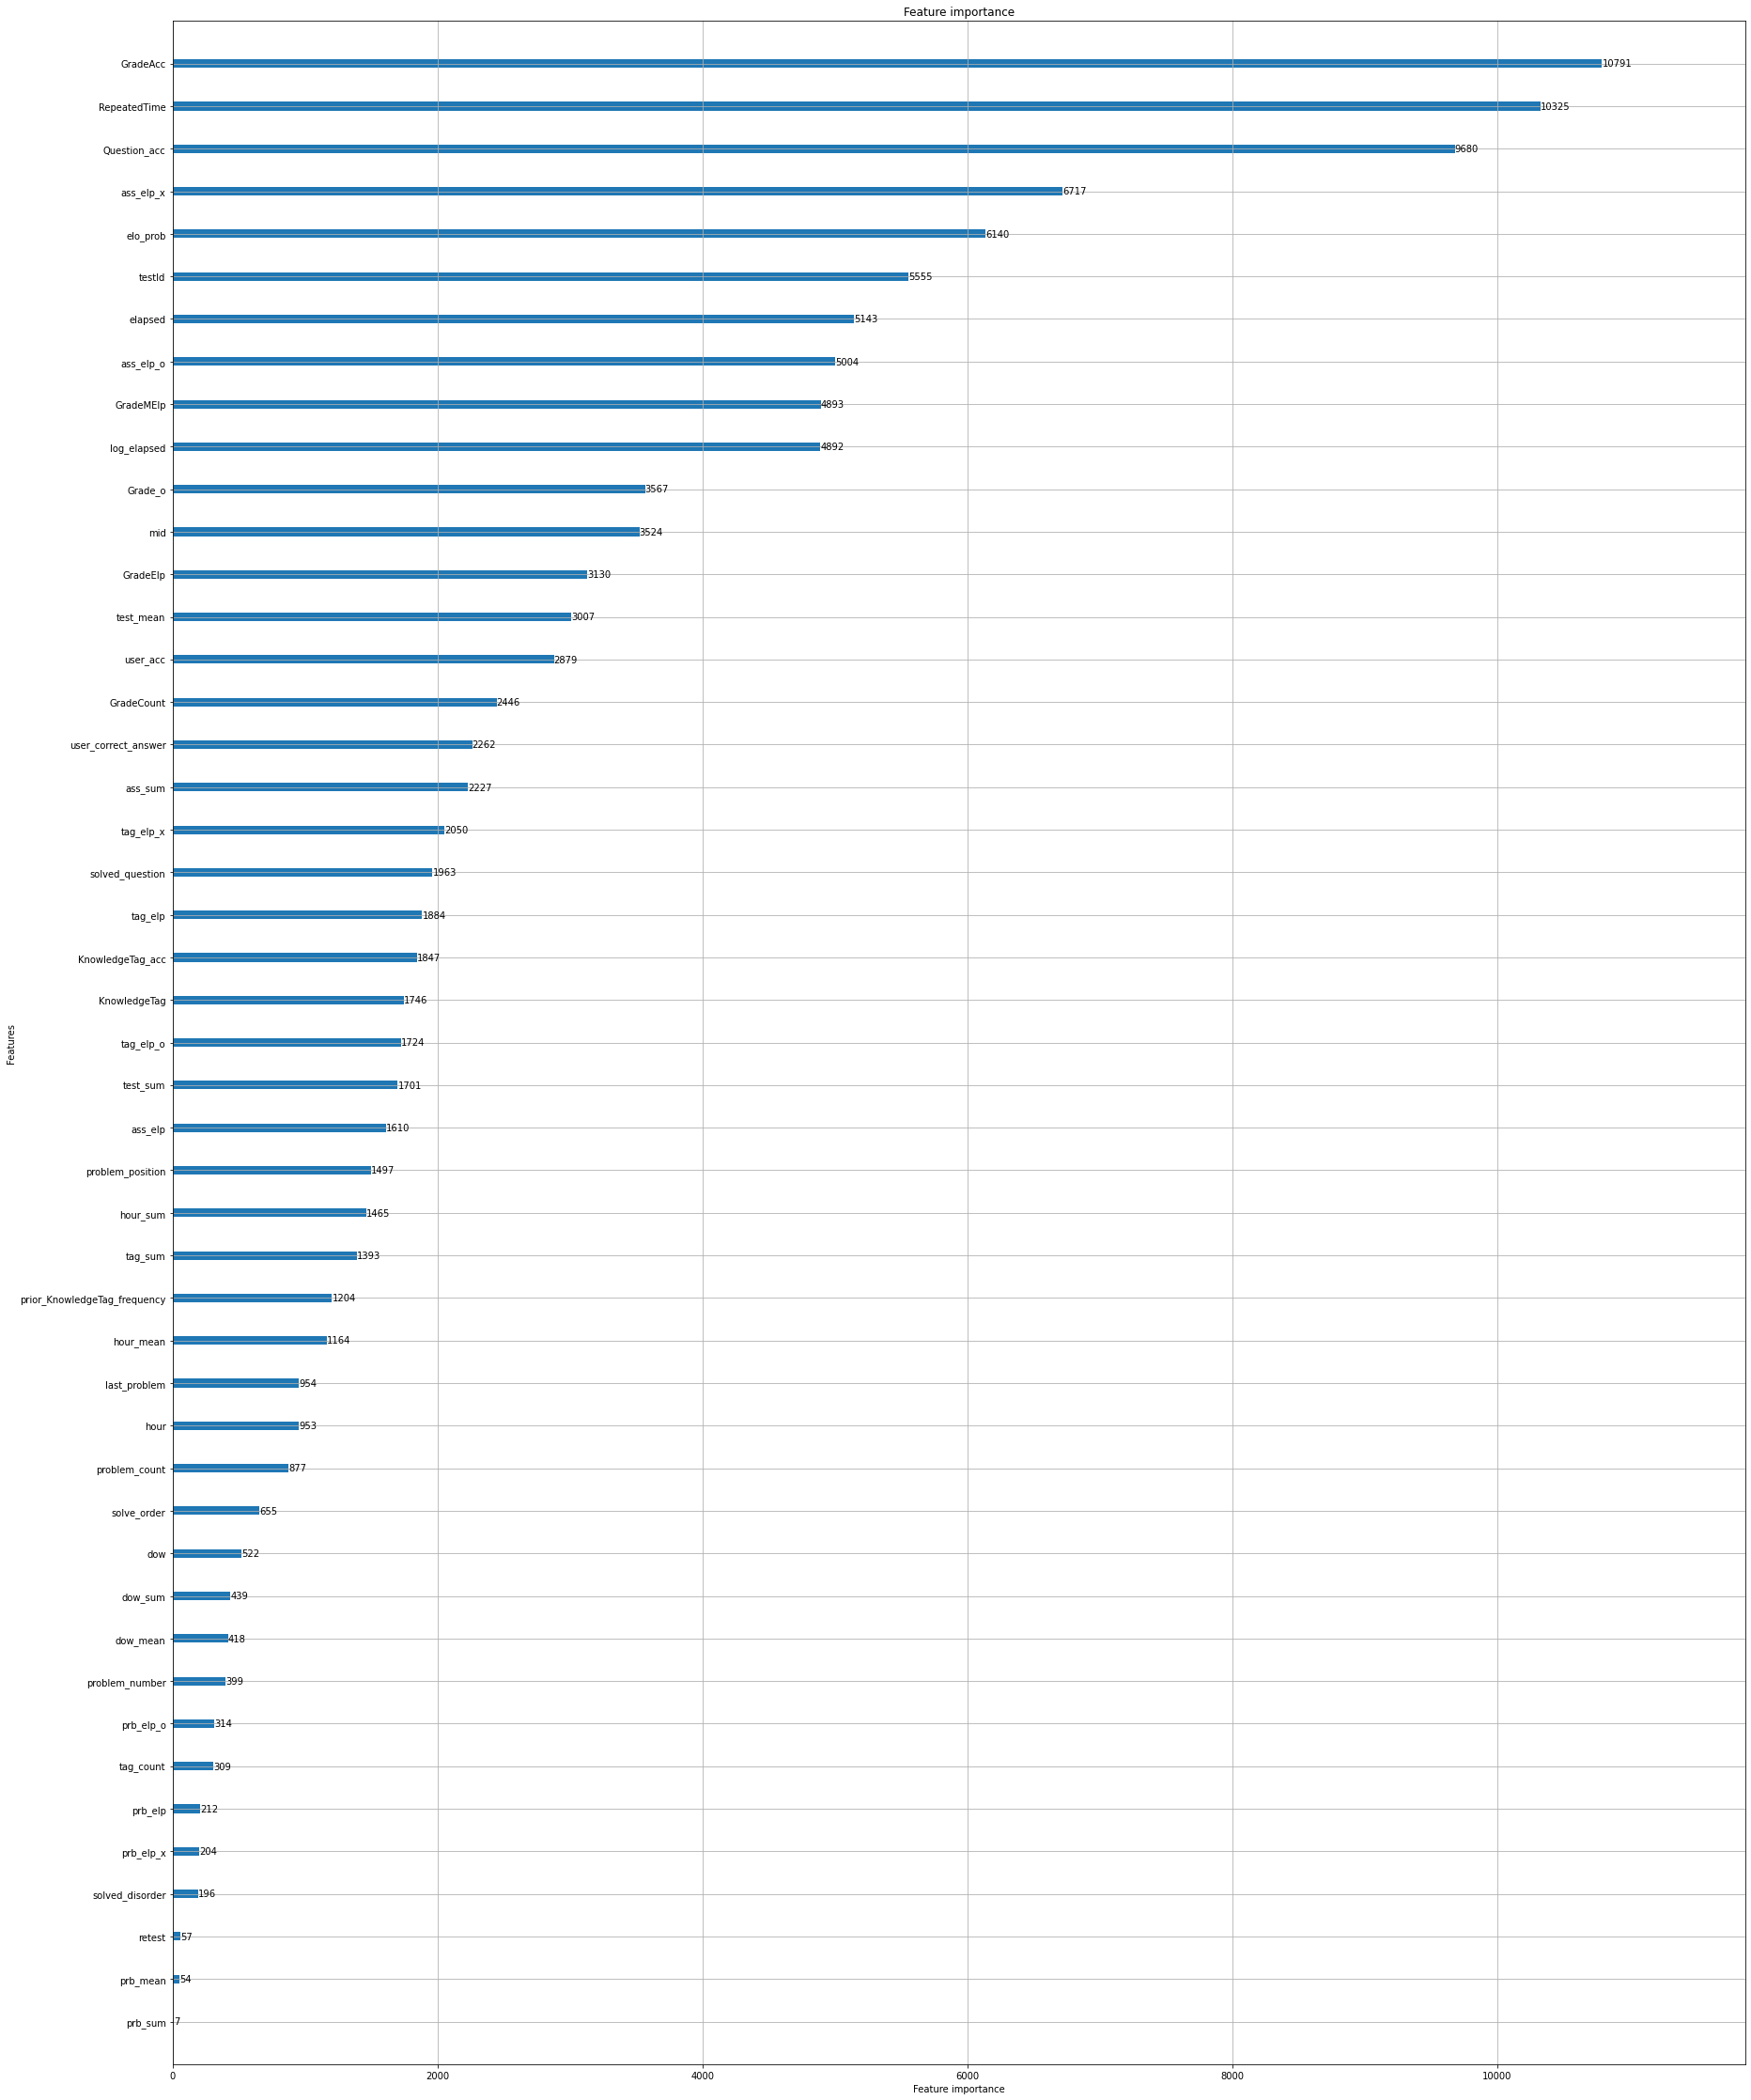

In [67]:
# Feature Importance 파악
import matplotlib.pyplot as plt
ax = lgb.plot_importance(train_again)
fig = ax.figure
fig.set_size_inches(30, 40)

# INFERENCE

In [68]:
# MAKE PREDICTION
total_preds = train_again.predict(test[FEATS])

In [69]:
# SAVE OUTPUT
output_dir = '/opt/ml/output/'
write_path = os.path.join(output_dir, "LGBM8.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : /opt/ml/output/LGBM8.csv


In [19]:
len(total_preds)

744

In [ ]:
pd_list[0]['prediction']
new_df = pd.DataFrame(columns=['prediction'])
for i in range(len(pd_list[0])):
    id=i
    a1 = pd_list[0]['prediction'][i] 
    a2 = pd_list[1]['prediction'][i] # 가장 높은 acc를 가진 prediction(이하 1번예측)
    a3 = pd_list[2]['prediction'][i]
    a4 = pd_list[3]['prediction'][i]

    d = {"up":[],"down":[]}

    for j in range(4): # 0.5를 기준으로 나눈다.
        if pd_list[j]['prediction'][i]>=0.5:
            d["up"].append(j)
        else:
            d["down"].append(j)

    if len(d["up"])>0 and len(d["down"])>0: 
        # 0.5를 기준으로 up, down이 있을 때, prediction을 max로 하여 auc를 늘림
        # 1번 예측이 어느 그룹에 포함되어 있을 때, 그 그룹에서 max 취함
        if (1 in d["up"]):
            m = pd_list[max(d["up"])]['prediction'][i]
        elif (1 in d["down"]):
            m = pd_list[max(d["down"])]['prediction'][i]
    else: # 네 개다 up 또는 down에 모두 있으면, max로 prediction 값을 구함
        m=(max(pd_list[0]['prediction'][i],pd_list[1]['prediction'][i],pd_list[2]['prediction'][i],pd_list[3]['prediction'][i]))
    
    new_df.loc[len(new_df)]=[m]